# Lab 3 — dimensionality reduction

**Group:** W

**Names:**

* Olivier Cloux
* Thibault Urien
* Saskia Reiss

In [1]:
# Given imports
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle as pk

# Import panda that is easier to use than dicts
import pandas as pd

# Import bokeh for 3.3
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()
from matplotlib.colors import rgb2hex 

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

Loading BokehJS ...

In [2]:
# Let's see whats inside those files to use them later.
#!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 1
#!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 1
#!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 1
#!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 1

### Introduction to the Data
To begin this lab, we choose to answer to the first questions asked in the handout, which are:
* How many different movies are there? How many tags, tag scores, movie ratings?
* How many movies have at least one tag?
* How many different movie genres are there?
* What are the shortest and longest movie titles? Tag names?

Note that we use panda, as we had a few problems with dictionnaries that we could not resolve. The Data Frames given by Panda being quite easy to use too.

In [3]:
#Data Frame of all tags ID
data_genome_tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2nameDF = pd.DataFrame(data_genome_tags.map(itemgetter("tagId", "tag")).collect(),columns = ["tagId", "tag"])
#tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())

# Data Frame of all movies and genres
data_movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
moviesDF = pd.DataFrame(data_movies.map(itemgetter("genres", "movieId", "title")).collect(),columns=["genres", "movieId", "title"])
genresListsDF = pd.DataFrame(data_movies.map(itemgetter("genres")).collect())
genresDF = pd.DataFrame(genresListsDF.values.flatten()).drop_duplicates().reset_index() #keep unique genres only

# Data Frame of all tag scores
data_genome_scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
tagScoresDF = pd.DataFrame(data_genome_scores.map(itemgetter("relevance", "tagId", "movieId")).collect(), columns=["relevance", "tagId", "movieId"])

#Data Frame of all ratings
data_ratings = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)
# data_ratings.groupBy(lambda x : x[0])
# #Still too big to call collect()# ratingsDF = pd.DataFrame((data3.groupBy(lambda x : x[0])).collect())

In [4]:
#Number of tags
print('There are',
      len(genresDF),'genres,',
      len(tag2nameDF),'tags', 
      data_ratings.count(),'ratings,', 
      len(moviesDF),'movies and',
      len(tagScoresDF),'tag scores')

#Find longest/shortest tag name 
tagLen = tag2nameDF.tag.map(len)
print('Longest tag name :',tag2nameDF.loc[tagLen.argmax(), 'tag'])
print('Shortest tag name :',tag2nameDF.loc[tagLen.argmin(), 'tag'])

#Find longest/shortest movie name
titleLen = moviesDF.title.map(len)
print('Longest film name :',moviesDF.loc[titleLen.argmax(), 'title'])
print('Shortest film name :',moviesDF.loc[titleLen.argmin(), 'title'])

#Number of movies and their tags
filmsWithTag = tagScoresDF.drop_duplicates(subset="movieId")['movieId']
print('There is a total of',len(moviesDF),'movies, of which', len(filmsWithTag),'have at least one tag')

There are 21 genres, 1128 tags 20000263 ratings, 27278 movies and 11709768 tag scores
Longest tag name : oscar (best writing - screenplay written directly for the screen)
Shortest tag name : 3d
Longest film name : Godzilla, Mothra, and King Ghidorah: Giant Monsters All-Out Attack (Gojira, Mosura, Kingu Gidorâ: Daikaijû sôkôgeki) (Godzilla, Mothra and King Ghidorah: Giant Monsters All-Out Attack) (2001)
Shortest film name : M (1931)
There is a total of 27278 movies, of which 10381 have at least one tag


#### Summary of above cell :
There are 27'278 movies, 20'000'263 ratings, 1'128 tags and 11'709'768 tag scores. There are 21 genres.

10'381 movies have at least one tag, which is a bit less than half of them.

The longest movie title is *Godzilla, Mothra, and King Ghidorah: Giant Monsters All-Out Attack (Gojira, Mosura, Kingu Gidorâ: Daikaijû sôkôgeki) (Godzilla, Mothra and King Ghidorah: Giant Monsters All-Out Attack) (2001)* which is 191 characters long. The shortest title is *M (2001)*.

The longest tag is *oscar (best writing - screenplay written directly for the screen)* and the shotest is *3d*

### Exercise 3.1
MxN matrix

In [5]:
# Create the M*N tag relevance matrix.
# The tags column is determied by its id.

#  M value. Count number of tag to know dimension of matrix.
tagCount = tagScoresDF.tagId.drop_duplicates().shape[0]
# Debugging line
print("There are",tagCount,"distinct tags")

# List of all movies who have at least one tag. Used to do index table, 
# to be able to map the position of movie in matrix to it's Id in the table
tagged_movies_id = tagScoresDF.movieId.drop_duplicates()
# Create index over movieId. Not all movies have a tag, the movie row is determined by its position in a indexing table
tagged_movies_id_index = pd.Index(tagged_movies_id)
# N value.
tagged_movies_count = tagged_movies_id.shape[0]

# Debugging line
print("There are",tagged_movies_count,"movies with at least one tag")

# Empty matrix
tags_mx = np.zeros((tagCount,tagged_movies_count))


# Fill the matrix by iterating over our Panda table y putting the position in the index in the matrix
for tagEntry in tagScoresDF.itertuples():
    tags_mx[tagEntry.tagId-1][tagged_movies_id_index.get_loc(tagEntry.movieId)] = tagEntry.relevance


There are 1128 distinct tags
There are 10381 movies with at least one tag


Plot the variance of each dimension/tag : 
The higher the variance, the more relevant to a film it is, as it is very movie specific. A tag with low variance is 

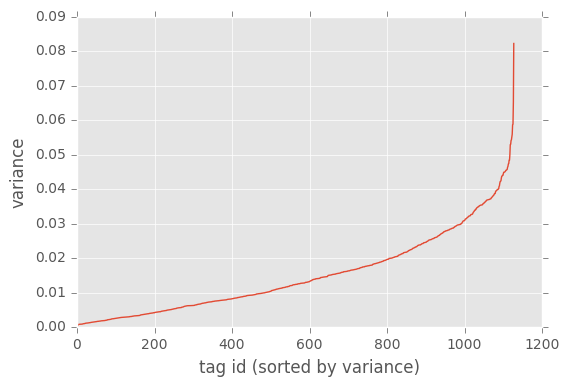

(500,) (501,)


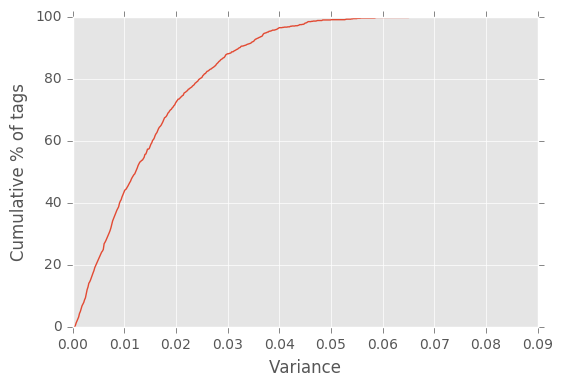

In [6]:
#Use variance function to get the variance. Sort it to get cumulative plot.
tag_variance = np.sort(np.var(tags_mx,1))

# Plot the variance by increasing order.
plt.ylabel("variance")
plt.xlabel("tag id (sorted by variance)")
plt.plot(tag_variance)
plt.show()

# Get cumulative plot.
values_var, base_var = np.histogram(tag_variance,bins=500,range=[0,max(tag_variance)])
cumulative_var = np.cumsum(values_var)
print(values_var.shape,base_var.shape)
plt.xlabel("Variance")
plt.ylabel("Cumulative % of tags")
plt.plot(base_var[:-1],cumulative_var/cumulative_var[-1]*100)
plt.show()


Plot the eigenvalue of the covariance matrix

In [7]:
# Use the covariance function.
tag_cov = np.cov(tags_mx)
# Use the eigenvalue function on the covariance.
w,v = np.linalg.eigh(tag_cov) #w = eigenvalues (sorted ascending), v = eigenvectors
# Plot the cumulative of the eigenvalues.
# values_eig, base_eig = np.histogram(tag_variance,bins=1000,range=[0,w[-1]])
cumulative_eig = np.cumsum(w)
print(len(cumulative_eig))

1128


We need  37  to retain  66 % of the information


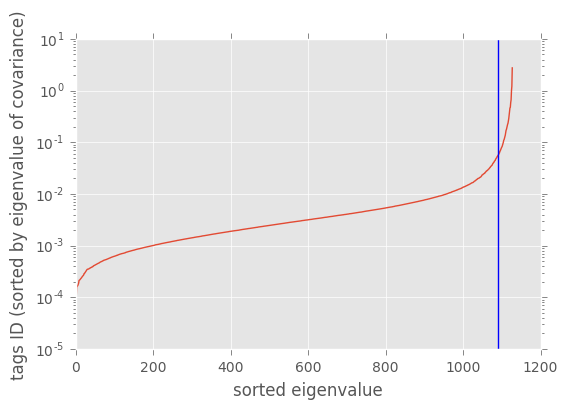

In [8]:
retained_info = 2/3

ratio = cumulative_eig/cumulative_eig[-1]
numConcepts = len(ratio[ratio > 1-retained_info])
print("We need ",numConcepts," to retain ",int(100*retained_info),"% of the information")

plt.xlabel("sorted eigenvalue")
plt.ylabel("tags ID (sorted by eigenvalue of covariance)")
# plt.subplot(1,1)
plt.plot(w)
plt.yscale('log')
plt.axvline(len(w)-numConcepts)
plt.show()

As we can see above, the end of the curve is really steep on the first graph. This indicates only the first values are significative. To have a better view, we also plot a log-plot. We immediately see that by taking only few values (here 37), we immediately capture 2/3 of the 'energy'. 

This means that we can capture 2/3 of the dimensions with 37 concepts (instead of 1000). 

### Exercise 3.2 : Concept Space

In [9]:
# (↕↕↕) : Each column is a principal directions 
five_first_dir =np.fliplr(v[:,-5:])
# 🚨 index of tags start at 0 but the numpy matrix index start at 1
# Top ten and bottom ten eigenvalues of tag relevance.
# Each column contain the index of the 10 tags with highest and lowest value vor a given direaction
ten_cardinal_tags_index = np.argpartition(five_first_dir, -10,0)[-10:]
ten_anticardinal_tags_index = np.argpartition(five_first_dir, 10,0)[:10]

print(np.argsort(five_first_dir[0])[-10:])
print(ten_cardinal_tags_index)
print(tag2nameDF[tag2nameDF["tagId"] == 88 +1])

ten_cardinal_tags = list(map(lambda x : tag2nameDF[tag2nameDF["tagId"].isin(list(x+1))],ten_cardinal_tags_index.T))
ten_anticardinal_tags = list(map(lambda x : tag2nameDF[tag2nameDF["tagId"].isin(list(x+1))],ten_anticardinal_tags_index.T))

[1 3 0 2 4]
[[ 211  906  386  121  127]
 [ 323  640  438 1091  682]
 [ 142   75  259  950  557]
 [ 749  269 1002 1089  896]
 [ 322  638  863  889  250]
 [ 535  845 1034  534 1024]
 [ 269  639  496  888  998]
 [ 935  609  899  886  999]
 [1007  442  613  885  688]
 [ 464  556  387 1090 1019]]
    tagId                tag
88     89  author:alan moore


In [10]:
for i in range(0,len(ten_cardinal_tags)):
    print("In category",i+1,"the cardinal tags are:\n",",".join(list(ten_cardinal_tags[i].tag)))
    print("And the anticardinal tags are:\n",",".join(list(ten_anticardinal_tags[i].tag)))
    print("********************************************************************************")
    

In categorie 1 the cardinal tags are:
 bleak,cinematography,criterion,drama,dramatic,great acting,imdb top 250,oscar (best directing),social commentary,talky
And the anticardinal tags are:
 bad plot,big budget,comedy,franchise,horrible,lame,predictable,silly,silly fun,so bad it's funny
********************************************************************************
In categorie 2 the cardinal tags are:
 art house,criterion,golden palm,intimate,loneliness,meditative,melancholic,melancholy,relationships,sexual
And the anticardinal tags are:
 action,action packed,big budget,chase,fast paced,good action,pg-13,plot,special effects,suspense
********************************************************************************
In categorie 3 the cardinal tags are:
 courage,feel good movie,feel-good,girlie movie,heartwarming,love story,romantic,sentimental,sweet,touching
And the anticardinal tags are:
 creepy,cult classic,cult film,dark,disturbing,horror,splatter,stylish,violence,weird
*************

The first five cardinal directions permits us to determine, thanks to the 10 tags, what each of the categories might be.

We determined the categories to be, in order:
1. Good movies, with the two axes being good and bad
2. Artistic Films, with the two axes being artistic and action
3. Romantic Comedies, with the two axes being sentiments and violence/horror
4. Science-Fiction, with the two axes being fiction and realism
5. Thriller, with the two axes being drama and comedy


Now, let's create the Python dict:

🥒Pickle the dictionary mapping tags name to coordinate in the 5 principle direction.🥒

In [11]:
tag_coord_in_ffd =five_first_dir.T @ tags_mx
tagCoord = {}
i = 1
for coord in tag_coord_in_ffd :
    tagCoord[list(tag2nameDF[tag2nameDF.tagId == i].tag)[0]]=coord
    i+=1

file = open("tagCoord.pickle",'wb')
pk.dump(tagCoord,file)   

### Exercise 3.3 : Movie visualization



In [12]:
# Let's open the pickle to load it.
with open( "selected-movies.pickle", "rb" ) as f:
    movie_rating_rt = pk.load( f, encoding="utf-8" )

In [13]:
# Given code for use of bokeh
# Continuous colors
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

# Define x and y, regaring the 2 fist dimensions
# w and v are still valid from before.
two_first_dir = five_first_dir[:,0:2]


#🚨 index of tags start at 0 but the numpy matrix index start at 1
movie_coord_in_tfd = two_first_dir.T @ tags_mx # matrix product
source = ColumnDataSource(
    data={
        "id": [x[0] for x in movie_rating_rt],
        "x": [movie_coord_in_tfd[0,tagged_movies_id_index.get_loc(x[0])] for x in movie_rating_rt],
        "y": [movie_coord_in_tfd[1,tagged_movies_id_index.get_loc(x[0])] for x in movie_rating_rt],
        "name": [x[1] for x in movie_rating_rt],
        "rating": [x[2] for x in movie_rating_rt],
        "color": [val2rgb(x[2]) for x in movie_rating_rt],
    })
      

hover = HoverTool(
    tooltips=[
        ("Name", "@name"), ("RT Rating", "@rating")
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="Movies on two principal directions and their Rotten Tomatoes (RT) rating")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

From what we know about the movies, the Rotten Romato scores, and what we see on the plot above , it seem that the X axis correspond to the “quality” of the movie while the values on the Y axis is high for movies focusing on sentiments and low for movie focusing on action. 
It seem that there is a noticeable correlation between first PCA and rotten tomato correlation.